# PBO max linear on the chain walk environment

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import jax
import os
import json

parameters = json.load(open("parameters.json"))
n_states = parameters["n_states"]
n_actions = 2
sucess_probability = parameters["sucess_probability"]
gamma = parameters["gamma"]
env_seed = parameters["env_seed"]

# Sample collection
n_repetitions = parameters["n_repetitions"]
n_samples = n_states * n_actions * n_repetitions

# Weights collection
n_weights = parameters["n_weights"]

# Trainings
max_bellman_iterations = parameters["max_bellman_iterations"]
training_steps = parameters["training_steps"]
fitting_steps = parameters["fitting_steps_pbo"]
batch_size_samples = parameters["batch_size_samples"]
batch_size_weights = parameters["batch_size_weights"]
initial_weight_std = parameters["initial_weight_std"]
learning_rate = {"first": parameters["starting_lr_pbo"], "last": parameters["ending_lr_pbo"], "duration": training_steps * fitting_steps * n_samples // batch_size_samples}

# Visualisation of errors and performances
max_bellman_iterations_validation = max_bellman_iterations + 20

# Search for an unused seed
max_used_seed = 0
if not os.path.exists("figures/data/PBO_max_linear/"):
    os.makedirs("figures/data/PBO_max_linear/")
for file in os.listdir("figures/data/PBO_max_linear/"):
    if int(file.split("_")[0]) == max_bellman_iterations and int(file.split("_")[2]) == n_repetitions and int(file.split("_")[3][:-4]) > max_used_seed:
        max_used_seed = int(file.split("_")[3][:-4])

# keys
env_key = jax.random.PRNGKey(env_seed)
seed = max_used_seed + 1
key = jax.random.PRNGKey(seed)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

## Define environment

In [2]:
import numpy as np
from pbo.environments.chain_walk import ChainWalkEnv


states = np.arange(n_states)
actions = np.arange(n_actions)
states_boxes = np.arange(n_states + 1) - 0.5
actions_boxes = np.arange(n_actions + 1) - 0.5

env = ChainWalkEnv(env_key, n_states, sucess_probability, gamma)

## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

for state in states:
    for action in actions:
        # Need to repeat the samples to capture the randomness
        for _ in range(n_repetitions):
            env.reset(jnp.array([state]))
            next_state, reward, absorbing, _ = env.step(jnp.array([action]))

            replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state, absorbing)

replay_buffer.cast_to_jax_array()

### Visualize samples

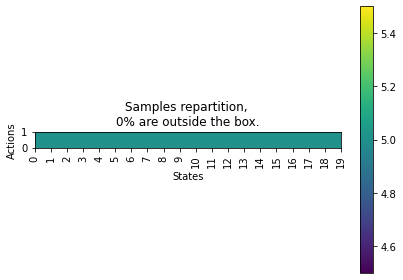

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes, _ = count_samples(replay_buffer.states, replay_buffer.actions, states_boxes, actions_boxes, replay_buffer.rewards)
samples_visu_mesh = TwoDimesionsMesh(states, actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)

## Collect weights

In [5]:
from pbo.weights_collection.weights_buffer import WeightsBuffer
from pbo.networks.learnable_q import TableQ


weights_buffer = WeightsBuffer()

# Add initial validation weights
q = TableQ(
    n_states=n_states,
    n_actions=n_actions,
    gamma=gamma,
    network_key=q_network_key,
    zero_initializer=True
)
validation_initial_weight = q.to_weights(q.params)

weights_buffer.add(validation_initial_weight)

# Add randow weights
q_random = TableQ(
    n_states=n_states,
    n_actions=n_actions,
    gamma=gamma,
    network_key=q_network_key,
    zero_initializer=False
)

while len(weights_buffer) < n_weights:
    weights = q_random.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train max linear PBO

In [6]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import MaxLinearPBO



data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo_max_linear = MaxLinearPBO(
    q=q,
    max_bellman_iterations=max_bellman_iterations,
    network_key=pbo_network_key,
    learning_rate=learning_rate,
    n_actions=n_actions,
    initial_weight_std=initial_weight_std
)
importance_iteration = jnp.ones(max_bellman_iterations + 1)

for _ in tqdm(range(training_steps)):
    params_target = pbo_max_linear.params
    for _ in range(fitting_steps):
        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo_max_linear.params, pbo_max_linear.optimizer_state, _ = pbo_max_linear.learn_on_batch(
                    pbo_max_linear.params, params_target, pbo_max_linear.optimizer_state, batch_weights, batch_samples, importance_iteration
                )

q_functions = np.zeros((max_bellman_iterations_validation + 1, n_states, n_actions))
bellman_iteration_functions = np.zeros((max_bellman_iterations_validation + 1, n_states, n_actions))
v_functions = np.zeros((max_bellman_iterations_validation + 1, n_states))

batch_iterated_weights = validation_initial_weight.reshape((1, -1))
for bellman_iteration in range(max_bellman_iterations_validation + 1):
    q_i = env.discretize(q, batch_iterated_weights[0], states, actions)
    policy_q = q_i.argmax(axis=1)

    q_functions[bellman_iteration] = q_i
    bellman_iteration_functions[bellman_iteration] = env.apply_bellman_operator(q_i)
    v_functions[bellman_iteration] = env.value_function(policy_q)
    print(policy_q)

    batch_iterated_weights = pbo_max_linear(pbo_max_linear.params, batch_iterated_weights)

  0%|          | 0/400 [00:00<?, ?it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 0 0 0]
[1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0]
[1 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0]
[1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0]
[1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1

## Save data

In [7]:
np.save(f"figures/data/PBO_max_linear/{max_bellman_iterations}_Q_{n_repetitions}_{seed}.npy", q_functions)
np.save(f"figures/data/PBO_max_linear/{max_bellman_iterations}_BI_{n_repetitions}_{seed}.npy", bellman_iteration_functions)
np.save(f"figures/data/PBO_max_linear/{max_bellman_iterations}_V_{n_repetitions}_{seed}.npy", v_functions)